In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
import sys; sys.path += ['..', '../src']

import os

DATA_PATH = '../data/generated'
read_data = lambda d: open(os.path.join(DATA_PATH, d)).read().splitlines()

In [3]:
# Reading datasets
train_full_src = read_data('news.ru.tok.ne.unk_ne')
train_full_trg = read_data('classics.split.tok.ne.unk_ne')

# Obtaining common words
get_words = lambda corpus: set(w for s in corpus for w in s.split())
words_src = get_words(train_full_src)
words_trg = get_words(train_full_trg)
common_words = words_src.intersection(words_trg)

print('Num src words:', len(words_src))
print('Num trg words:', len(words_trg))
print('Num common words:', len(common_words))

# Removing sentences with non-common vocabulary
remove_alien_sents = lambda x: [s for s in x if all(w in common_words for w in s.split())]
train_src_without_aliens = remove_alien_sents(train_full_src)
train_trg_without_aliens = remove_alien_sents(train_full_trg)

# Saving data
def save_data(corpus, name):
    with open(os.path.join(DATA_PATH, name), 'w') as out_file:
        for s in corpus:
            out_file.write(s + '\n')

save_data(train_src_without_aliens, 'news.ru.tok.ne.unk_ne.common')
save_data(train_trg_without_aliens, 'classics.split.tok.ne.unk_ne.common')

print('Num src sentences with common words:', len(train_src_without_aliens))
print('Num trg sentences with common words:', len(train_trg_without_aliens))

Num src words: 885607
Num trg words: 582227
Num common words: 280398
Num src sentences with common words: 2589578
Num trg sentences with common words: 1129608


In [13]:
# Now we learn bpes with the following script
# ./scripts/bpe.sh data/generated/news.ru.tok.ne.unk_ne.common data/generated/classics.split.tok.ne.unk_ne.common 16000

In [15]:
import os
from src.vocab import Vocab

train_src = read_data('news.ru.tok.ne.unk_ne.common.bpe')
train_trg = read_data('classics.split.tok.ne.unk_ne.common.bpe')

lens_src = [len(s.split()) for s in train_src]
lens_trg = [len(s.split()) for s in train_trg]

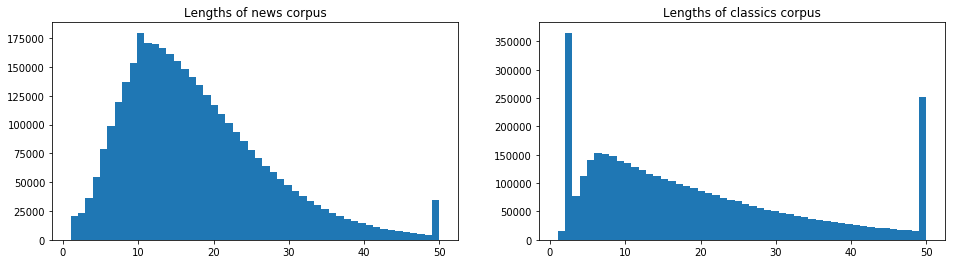

In [19]:
import numpy as np
import matplotlib.pyplot as plt

maxout = lambda lens: [min(l,50) for l in lens]

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('Lengths of news corpus')
plt.hist(maxout(lens_src), bins=50);

plt.subplot(122)
plt.title('Lengths of classics corpus')
plt.hist(maxout(lens_trg), bins=50);

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline
# % env CUDA_VISIBLE_DEVICES=0,1,2,3

import sys; sys.path += ['..', '../src']

import os

DATA_PATH = '../data/generated'
read_data = lambda d: open(os.path.join(DATA_PATH, d)).read().splitlines()

In [2]:
import os
from src.vocab import Vocab

train_src = read_data('news.ru.tok.ne.unk_ne.common.bpe')
train_trg = read_data('classics.split.tok.ne.unk_ne.common.bpe')

min_len = 10
max_len = 100

# Removing too short and too long sentences
print('Num lines before:', len(train_src), len(train_trg))
filter_by_length = lambda corpus: [s for s in corpus if min_len <= len(s.split()) <= max_len]
train_src = filter_by_length(train_src)
train_trg = filter_by_length(train_trg)
print('Num lines after :', len(train_src), len(train_trg))

Num lines before: 3523148 3955090
Num lines after : 2798683 2637276


In [3]:
from sklearn.model_selection import train_test_split

vocab = Vocab.from_sequences(train_src + train_trg)

tokenize = lambda corpus: [[vocab.token2id[t] for t in s.split()] for s in corpus]
train_src_idx = tokenize(train_src)
train_trg_idx = tokenize(train_trg)

train_src_idx, val_src_idx = train_test_split(train_src_idx, test_size=1000, random_state=42)
train_trg_idx, val_trg_idx = train_test_split(train_trg_idx, test_size=1000, random_state=42)

In [4]:
from src.models import TransformerWithTwoDecoders

transformer_kwargs = {
    'd_model': 256,
    'd_word_vec': 256
}

transformer = TransformerWithTwoDecoders(len(vocab), len(vocab), max_len+2, **transformer_kwargs)

In [5]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

# from src.trainers import StyleTransferTrainer
from src.trainers.style_transfer_trainer import StyleTransferTrainer
from src.dataloaders import UMTBatcher, Batcher
from src.vocab import constants
from src.utils.training_utils import cross_entropy_without_pads

use_cuda = torch.cuda.is_available()
log_file_path = '../logs/style-transfer.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

reconstruct_src_criterion = cross_entropy_without_pads(len(vocab))
reconstruct_trg_criterion = cross_entropy_without_pads(len(vocab))

transformer_optimizer = Adam(transformer.trainable_parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab,
                           vocab, batch_size=16, shuffle=True)
val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab.token2id,
                   vocab.token2id, batch_size=16, shuffle=False)

config = {
    'max_num_epochs': 50,
    'start_bt_from_iter': 30000,
    'log_file': log_file_path
}

trainer = StyleTransferTrainer(
    transformer, transformer_optimizer, vocab, vocab,
    reconstruct_src_criterion, reconstruct_trg_criterion, config)

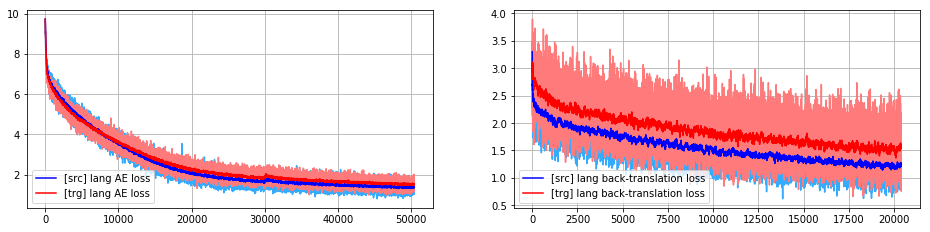

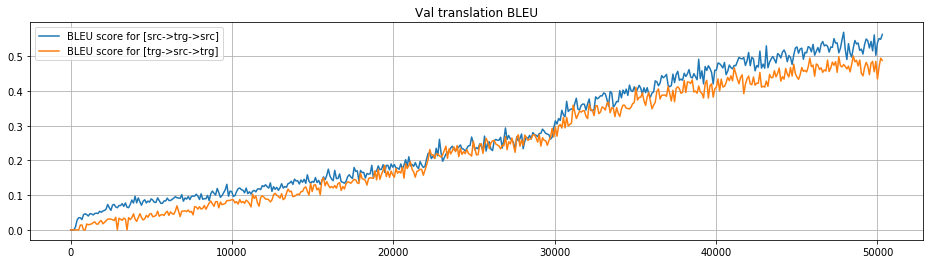

 17%|█▋        | 28203/164768 [20:49:15<100:49:12,  2.66s/it]


In [7]:
trainer.run_training(training_data, val_data, plot_every=10, val_bleu_every=100)